# TIME SERIES FORESCASTING
## Bisnis Understanding
Notebook ini bertujuan untuk memprediksi kualitas udara harian berdasarkan konsentrasi Nitrogen Dioksida (NO₂). NO₂ merupakan salah satu indikator utama pencemaran udara yang dihasilkan dari aktivitas transportasi, industri, dan pembakaran bahan bakar fosil. Kadar NO₂ yang tinggi dapat berdampak negatif terhadap kesehatan manusia serta kualitas lingkungan.

Melalui analisis ini, dilakukan pendekatan time series forecasting untuk menganalisis pola perubahan harian konsentrasi NO₂ selama periode 1 bulan pada tanggal 20-09-2025 sd 16-10-2025 di Kota Jakarta. Tujuannya adalah untuk memprediksi kadar NO₂ pada tanggal 17-10-2025.



## Data Understanding
Dataset yang digunakan adalah dataset citra satelit (NO₂) yang diambil melalui platform Dataspace Copernicus. Dokumentasi pengambilan data NO₂ dapat diakses melalui link berikut: Dokumentasi. Pengambilan titik koordinat suatu daerah dapat menggunakan platform geojson. Pada Notebook ini, digunakan kordinat poligon dari suatu Kota yaitu jakarta yang dapat dilihat pada gambar di bawah ini:
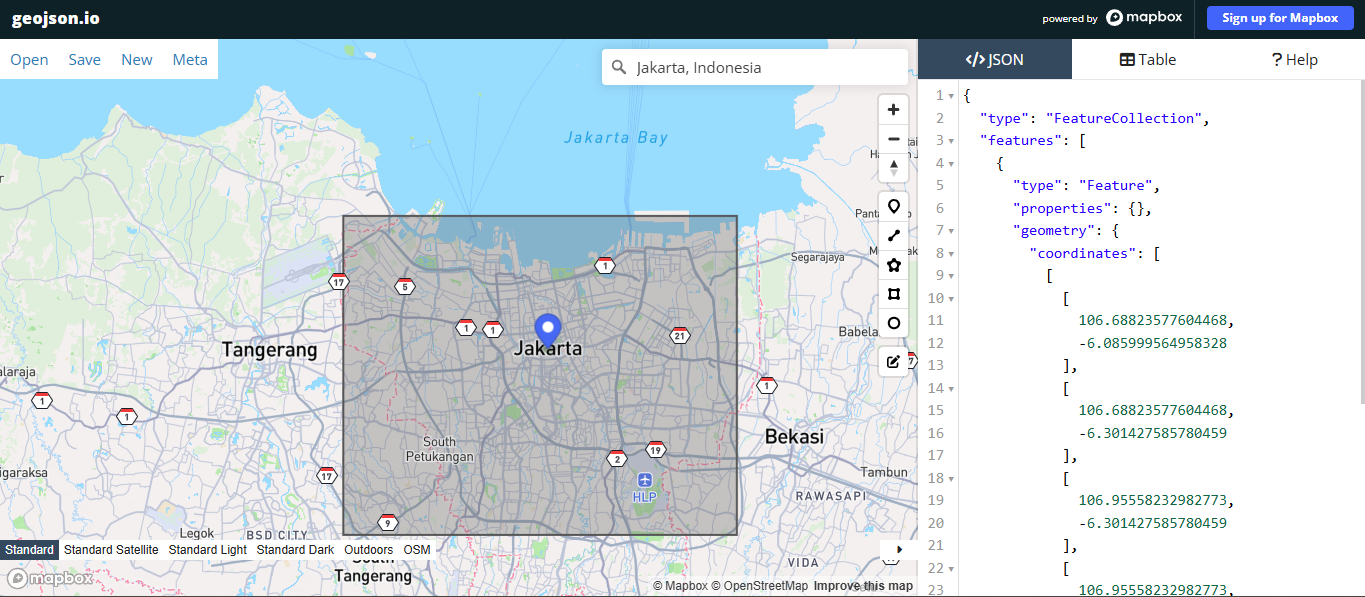

## mengambil data
Berikut adalah kode yang digunakan untuk mengambil data berdasarkan kordinat poligon yang sudah didapatkan:

In [4]:
import openeo
from shapely.geometry import shape

In [22]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [35]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [106.68823577604468, -6.085999564958328],
            [106.68823577604468, -6.301427585780459],
            [106.95558232982773, -6.301427585780459],
            [106.95558232982773, -6.085999564958328],
            [106.68823577604468, -6.085999564958328],
        ]
    ],
}

In [36]:
prob = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2025-09-20", "2025-10-20"],
    spatial_extent={
        "west": 106.68823577604468,
        "south": -6.301427585780459,
        "east": 106.95558232982773,
        "north": -6.085999564958328,
    },
    bands=["NO2"],
)


In [37]:
# Buat FeatureCollection dari AOI
feature = {"type": "Feature", "geometry": aoi, "properties": {"id": 1}}
fc = {"type": "FeatureCollection", "features": [feature]}

In [38]:
# Agregasi temporal harian untuk rata-rata per hari
prob = prob.aggregate_temporal_period(reducer="mean", period="day")

# Agregasi spasial: rata-rata nilai NO2 dalam AOI
prob = prob.aggregate_spatial(reducer="mean", geometries=fc)

In [39]:
job = prob.execute_batch(
    title="NO2 Kota Jakarta Sep-Okt 2025",
    outputfile="no2_jakarta.nc"
)

0:00:00 Job 'j-2510251038274043809272c92890e097': send 'start'
0:00:13 Job 'j-2510251038274043809272c92890e097': created (progress 0%)
0:00:19 Job 'j-2510251038274043809272c92890e097': created (progress 0%)
0:00:27 Job 'j-2510251038274043809272c92890e097': created (progress 0%)
0:00:35 Job 'j-2510251038274043809272c92890e097': created (progress 0%)
0:00:45 Job 'j-2510251038274043809272c92890e097': running (progress N/A)
0:00:58 Job 'j-2510251038274043809272c92890e097': running (progress N/A)
0:01:13 Job 'j-2510251038274043809272c92890e097': running (progress N/A)
0:01:33 Job 'j-2510251038274043809272c92890e097': running (progress N/A)
0:01:57 Job 'j-2510251038274043809272c92890e097': finished (progress 100%)


## convert to CSV
Dataset yang dihasilkan berupa file NetCDF (.nc). Untuk mempermudah pemrosesan data kita perlu konversi menjadi format dataset umum seperti (.csv). Berikut adalah kode yang dapat digunakan untuk mengonversi file (.nc) ke (.csv):

In [42]:
import xarray as xr

# open dataset NetCDF
ds = xr.open_dataset("no2_jakarta.nc")

# lihat isi untuk menyesuaikan transformasi
print(ds)

df = ds.to_dataframe().reset_index()

# Ambil kolom waktu dan NO2
df = df[['t', 'NO2']]

# Simpan ke CSV
df.to_csv("NO2.csv", index=False)

<xarray.Dataset> Size: 344B
Dimensions:        (t: 20, feature: 1)
Coordinates:
  * t              (t) datetime64[ns] 160B 2025-09-21 2025-09-22 ... 2025-10-16
    lat            (feature) float64 8B ...
    lon            (feature) float64 8B ...
    feature_names  (feature) int64 8B ...
Dimensions without coordinates: feature
Data variables:
    NO2            (feature, t) float64 160B ...
Attributes:
    Conventions:  CF-1.8
    source:       Aggregated timeseries generated by openEO GeoPySpark backend.


## Exploratory Data Analysis (EDA)
Setelah berhasil mendapatkan data dalam bentuk (.csv), langkah selanjutnya adalah melihat/mengeksplor kondisi data

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [49]:
no2_asli = pd.read_csv('/content/NO2.csv')
no2_asli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       20 non-null     object 
 1   NO2     20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 452.0+ bytes


In [53]:
# Ubah kolom 'date' menjadi tipe datetime
no2_asli['t'] = pd.to_datetime(no2_asli['t'])
no2_asli.info()

no2 = no2_asli.copy()

# Urutkan data berdasarkan tanggal
no2 = no2.sort_values('t')

# Set kolom 't' sebagai index
no2 = no2.set_index('t')
print(no2.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t       20 non-null     datetime64[ns]
 1   NO2     20 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 452.0 bytes
                 NO2
t                   
2025-09-21  0.000058
2025-09-22  0.000132
2025-09-23  0.000194
2025-09-24  0.000205
2025-09-25  0.000048


In [54]:
# MEMERIKSA MISSING DATES

# Cek rentang tanggal lengkap (harian)
tanggal_lengkap = pd.date_range(start=no2.index.min(), end=no2.index.max(), freq='D')

print(tanggal_lengkap)

# Cari tanggal yang hilang
tanggal_hilang = tanggal_lengkap.difference(no2.index)

print("Tanggal yang hilang:\n", tanggal_hilang)

DatetimeIndex(['2025-09-21', '2025-09-22', '2025-09-23', '2025-09-24',
               '2025-09-25', '2025-09-26', '2025-09-27', '2025-09-28',
               '2025-09-29', '2025-09-30', '2025-10-01', '2025-10-02',
               '2025-10-03', '2025-10-04', '2025-10-05', '2025-10-06',
               '2025-10-07', '2025-10-08', '2025-10-09', '2025-10-10',
               '2025-10-11', '2025-10-12', '2025-10-13', '2025-10-14',
               '2025-10-15', '2025-10-16'],
              dtype='datetime64[ns]', freq='D')
Tanggal yang hilang:
 DatetimeIndex(['2025-09-29', '2025-09-30', '2025-10-01', '2025-10-02',
               '2025-10-06', '2025-10-07'],
              dtype='datetime64[ns]', freq=None)


Dari hasil pengecekan di atas, terdapat missing date pada tanggal [‘2025-09-29’, ‘2025-09-30’, ‘2025-10-01’, ‘2025-10-02’, ‘2025-10-06’, ‘2025-10-07’].
Kehilangan data pada tanggal-tanggal tersebut menunjukkan bahwa terdapat missing value dalam deret waktu (time series) yang dapat disebabkan oleh beberapa faktor, seperti kesalahan pengambilan data satelit, gangguan cuaca, atau keterlambatan akuisisi data.
Missing dates tersebut perlu dilakukan proses imputasi atau interpolasi sebelum melanjutkan ke tahap analisis atau pemodelan, karena data yang tidak lengkap dapat memengaruhi akurasi hasil analisis dan performa model prediksi nantinya.

## Pre-Processing
Tahap ini akan melakukan proses awal data untuk menangani missing dates yang sudah ditemukan pada tahap Data Understanding serta mengubah data Time Series menjadi data Supervied.
### Menangani Missing Value
Dates yang hilang akan ditambahkan dan value NO2 pada dates baru akan diisi menggunakan teknik Interpolasi linear.



In [55]:
# Reindex dataframe agar semua tanggal muncul
no2 = no2.reindex(tanggal_lengkap)
print(no2.head(10))

# Interpolasi nilai yang hilang (linear interpolation)
no2 = no2.interpolate(method='linear')

# Reset index dan ubah nama kolom index ke 'date' kembali
no2 = no2.reset_index().rename(columns={'index': 'date'})

# Cek hasil
# print(no2.head())
print("\nJumlah missing value setelah interpolasi:")
print(no2.isna().sum())

                 NO2
2025-09-21  0.000058
2025-09-22  0.000132
2025-09-23  0.000194
2025-09-24  0.000205
2025-09-25  0.000048
2025-09-26  0.000152
2025-09-27  0.000123
2025-09-28  0.000062
2025-09-29       NaN
2025-09-30       NaN

Jumlah missing value setelah interpolasi:
date    0
NO2     0
dtype: int64


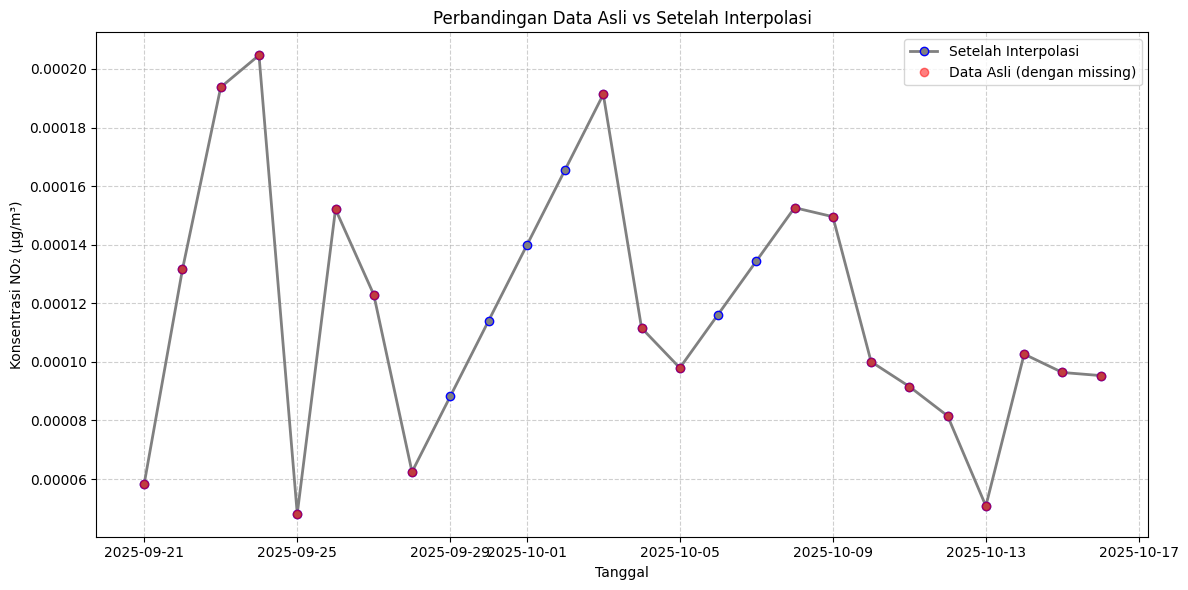

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(no2['date'], no2['NO2'], linestyle='-', color='grey', linewidth=2,  marker='o', markeredgecolor='blue', label='Setelah Interpolasi')
plt.plot(no2_asli['t'], no2_asli['NO2'], 'ro', alpha=0.5, label='Data Asli (dengan missing)')
plt.title('Perbandingan Data Asli vs Setelah Interpolasi')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂ (µg/m³)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Dari grafik terlihat bahwa:

- Titik merah merepresentasikan data asli yang memiliki beberapa nilai missing (hilang) pada rentang tanggal tertentu, seperti 29–30 September dan 6–7 Oktober 2025.
- Titik biru menunjukkan nilai hasil interpolasi, yaitu nilai perkiraan yang diisi berdasarkan pola perubahan data di sekitar tanggal yang hilang.
- Garis abu-abu menghubungkan seluruh titik untuk menunjukkan tren perubahan konsentrasi NO₂ dari waktu ke waktu.

Secara visual, hasil interpolasi mengikuti pola data asli dengan mulus tanpa menyebabkan lonjakan atau penurunan ekstrem. Hal ini menunjukkan bahwa metode interpolasi yang digunakan berhasil mengisi kekosongan data secara konsisten dan mempertahankan karakteristik tren deret waktu.

Dengan demikian, data hasil interpolasi ini dapat digunakan untuk analisis selanjutnya (misalnya perhitungan tren atau pemodelan prediktif) karena telah bebas dari missing value yang dapat mengganggu akurasi model.

### Mengubah Data menjadi Supervised
Pada tahap ini, data time series yang sudah lengkap akan diubah menjadi data supervised menggunakan teknik sliding windows. Teknik ini sederhananya memanfaatkan data masa lalu menjadi fitur/input. Misalnya kita akan memanfaatkan hari kemarin (t-2), hari ini (t-1) sebagai fitur untuk memprediksi hari esok (t). Data masa lalu atau disebut sebagai lag ukurannya bisa menyesuaikan dengan data masing-masing untuk mendapat akurasi terbaik. Pada eksperimen yang saya lakukan, ukuran terbaiknya adalah 4, jadi pada notebook ini data supervised memanfaatkan 4 hari masa lalu untuk memprediksi hari berikutnya.

In [59]:
supervised = pd.DataFrame()
# supervised['t-7'] = no2['NO2'].shift(7)
# supervised['t-6'] = no2['NO2'].shift(6)
# supervised['t-5'] = no2['NO2'].shift(5)
supervised['t-4'] = no2['NO2'].shift(4)
supervised['t-3'] = no2['NO2'].shift(3)
supervised['t-2'] = no2['NO2'].shift(2)
supervised['t-1'] = no2['NO2'].shift(1)
supervised['t'] = no2['NO2']

In [60]:
supervised = supervised.dropna().reset_index(drop=True)
print(supervised.head())

        t-4       t-3       t-2       t-1         t
0  0.000058  0.000132  0.000194  0.000205  0.000048
1  0.000132  0.000194  0.000205  0.000048  0.000152
2  0.000194  0.000205  0.000048  0.000152  0.000123
3  0.000205  0.000048  0.000152  0.000123  0.000062
4  0.000048  0.000152  0.000123  0.000062  0.000088


### normalisasi data
Pada tahap ini data supervised yang sudah dihasilkan akan dinormalisasi menggunakan teknik MinMaxScaler. MinMaxScaler akan mengubah fitur (kolom data) dengan menskalakan setiap nilai dalam rentang tertentu, biasanya antara 0 dan 1. Pada notebook ini, range yang akan digunakan antara 0 dan 1. Jadi nilai minimum fitur asli akan menjadi 0, dan nilai maksimum fitur asli akan menjadi 1.

In [61]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_values = scaler.fit_transform(supervised)
scaled = pd.DataFrame(scaled_values, columns=supervised.columns)

print(scaled.head())

        t-4       t-3       t-2       t-1         t
0  0.065822  0.533144  0.930352  1.000000  0.000000
1  0.533144  0.930352  1.000000  0.000000  0.726180
2  0.930352  1.000000  0.000000  0.664236  0.522455
3  1.000000  0.000000  0.664236  0.477889  0.099882
4  0.000000  0.664236  0.477889  0.091362  0.279906


## modeling
Pada tahap ini, kita akan menggunakan model KNN Regressor yang disediakan oleh library Sklearn untuk training dan testing data. Selanjutkan kita akan ukur akurasi model menggunakan Mean Squared Error (MSE) dan R^2.

In [62]:
X = scaled.drop('t', axis=1)
y = scaled['t']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [64]:
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Squared Error: 0.1205
R^2 Score: -8.0018


Dapat dilihat dari hasil interpolasi pada grafik di atas, proses pengisian data yang hilang telah berhasil mengikuti pola perubahan konsentrasi NO₂ secara keseluruhan. Nilai hasil interpolasi (titik biru) tampak selaras dengan tren data asli (titik merah), tanpa menyebabkan perubahan ekstrem yang dapat mengganggu pola harian.

Meskipun demikian, hasil interpolasi ini masih memiliki potensi untuk diperbaiki, terutama jika terdapat fluktuasi tajam pada data asli yang sulit ditangkap oleh metode interpolasi linear. Akurasi hasil interpolasi sangat bergantung pada jumlah dan distribusi data di sekitarnya — jika data harian terlalu sedikit atau memiliki variasi tinggi, maka nilai interpolasi bisa kurang merepresentasikan kondisi sebenarnya.

Secara umum, hasil ini menunjukkan bahwa metode interpolasi yang digunakan sudah cukup baik dalam mengatasi missing value tanpa mengubah karakteristik utama data. Dengan kata lain, dataset setelah interpolasi dapat digunakan untuk tahap analisis selanjutnya (seperti peramalan atau pemodelan time series) karena pola harian konsentrasi NO₂ tetap terjaga dengan baik.

In [65]:
result = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}).reset_index(drop=True)

print("\nContoh hasil prediksi:")
print(result.head())


Contoh hasil prediksi:
     Actual  Predicted
0  0.362594   0.578433
1  0.303358   0.655698
2  0.233382   0.566227
3  0.018573   0.530807
4  0.380699   0.605784


Dari hasil training model yang sudah dilakukan, berikut adalah hasil prediksi untuk tanggal 17-10-2025:



In [67]:
last_input = scaled.drop('t', axis=1).iloc[-1].values.reshape(1, -1)
next_pred_scaled = knn.predict(last_input)
next_pred = scaler.inverse_transform(
    np.hstack((last_input, next_pred_scaled.reshape(-1, 1)))
)[0, -1]

# Buat tanggal baru untuk prediksi
next_date = (pd.to_datetime(no2['date'].iloc[-1]) + pd.Timedelta(days=1)).date()

print(f'\nPrediksi NO2 pada {next_date}: {next_pred}')


Prediksi NO2 pada 2025-10-17: 0.0001430102326905187


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


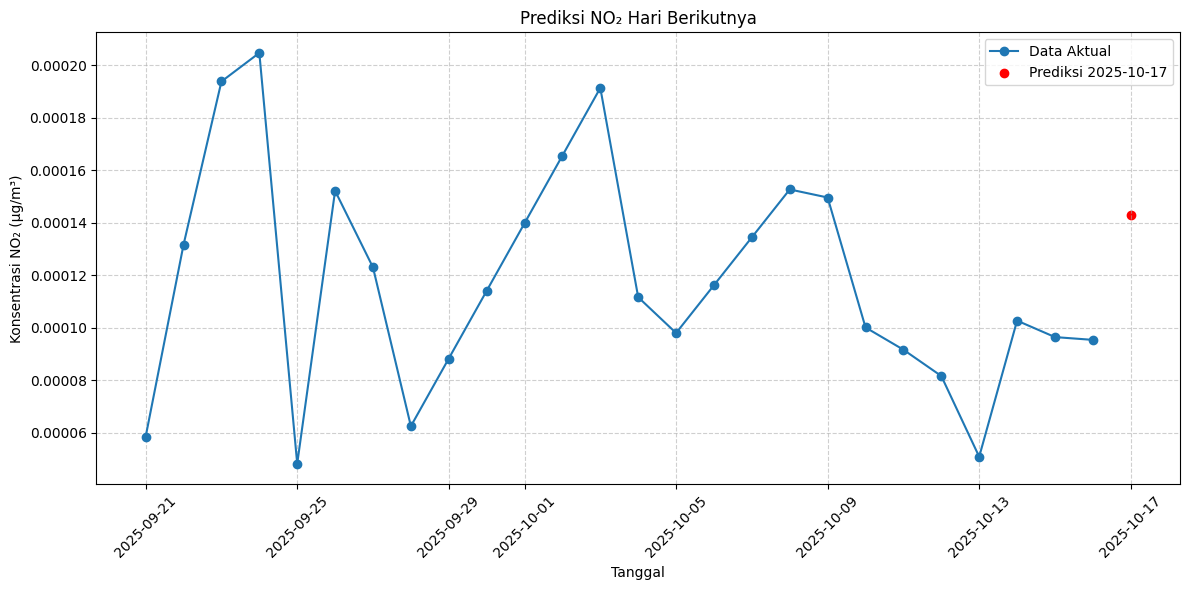

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(no2['date'], no2['NO2'], marker='o', label='Data Aktual')
plt.scatter(next_date, next_pred, color='red', label=f'Prediksi {next_date}')

plt.title('Prediksi NO₂ Hari Berikutnya')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂ (µg/m³)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()